In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath

In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (3,1.5)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

# # FUNCTIONS
def recreate_config(experiment):
    with initialize(version_base=None, config_path="../configs"):
        cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}"],return_hydra_config=True,)
        HydraConfig.instance().set_config(cfg)

    for k in cfg.paths.keys():
        if (k != 'user'):
            cfg.paths[k] = Path(cfg.paths[k])
            cfg.paths[k].mkdir(parents=True, exist_ok=True)

    return cfg

In [3]:
experiment = "DNg100_1000_replicates"
version = "debug"
run_id = "walle"

config = recreate_config(experiment)
name = config.experiment.name
RPath = f"/data/users/smpuglie/Pugliese_2025/{name}/{config.version}/run_id={run_id}/ckpt/{name}_Rs.npz"
Rs = sparse.load_npz(RPath).todense()

In [4]:
dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1000, 3308, 2000)

## plot an individual simulation

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


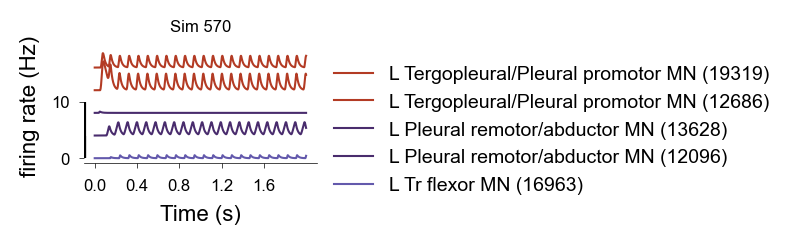

Rhythmicity score:  0.779
Frequency:  11.364 Hz


In [6]:
simToPlot = np.random.randint(nSims)
spacer = 4
scalebar = 10
width = 1.5

###
R = Rs[simToPlot]

wTable = pd.read_csv(config.experiment.dfPath)
allMNs = sort_motor_modules(wTable.loc[(wTable["class"] == "motor neuron")&(wTable["subclass"] == "fl")])

plt.figure()
ax = plot_R_traces_stacked_by_module(R,allMNs,activeOnly=True,space=spacer)
add_tAxis(ax,config.sim.T,5)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
fig.set_figheight(0.15*len(get_active_data(R[allMNs.index],allMNs)))
fig.set_figwidth(width)
plt.title(f"Sim {simToPlot}")

plt.show()

# activeMNs = get_active_data(R[allMNs.index],allMNs)
activeMnsMask = (np.sum(R,1)>1) & (jnp.isin(jnp.arange(R.shape[0]), allMNs.index.to_numpy()))
score, freq = compute_oscillation_score(R[...,250:],activeMnsMask)# ,returnFrequency=True)
print(f"Rhythmicity score: {float(score): .3f}")
print(f"Frequency: {float(freq) / config.sim.dt: .3f} Hz")

## calculate and plot overall stats

In [ ]:
nActive = np.sum(np.sum(Rs,axis=2)>1,axis=1)
print(f"{sum(nActive>=1000)} overactive simulations")
print(f"{sum(nActive<=5)} underactive simulations")

In [ ]:
mnActive = pd.DataFrame(index=allMNs.index)
mnScore = pd.DataFrame(index=allMNs.index)
mnFreq = pd.DataFrame(index=allMNs.index)
mnMaxFr = pd.DataFrame(index=allMNs.index)

for i in range(nSims):
    # active neurons
    mnActive[i] = np.zeros(len(mnActive))
    mnScore[i] = np.nan
    mnFreq[i] = np.nan
    activeMnIdxs = get_active_data(Rs[i][mnActive.index],mnActive).index
    mnActive.loc[activeMnIdxs,i] = 1

    # osc scores and frequencies
    for mnIdx in activeMnIdxs:
        score, freq = neuron_oscillation_score(Rs[i][mnIdx][250:]) # CHANGED TO 250

        mnScore.loc[mnIdx,i] = score
        mnFreq.loc[mnIdx,i] = freq / config.sim.dt

        mnMaxFr.loc[mnIdx,i] = np.max(Rs[i][mnIdx][250:])

In [ ]:
plt.figure(figsize=(0.457,0.540))
ax = sns.histplot(np.sum(mnActive,axis=0),color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1)#,label="good sims")
plt.ylim([0,480])
plt.xlim([0,12])
plt.xticks([0,5,10])
plt.ylabel("# replicates")
plt.xlabel("# MNs active")

plt.savefig(config.paths.fig_dir / f"{name}_activeMnHist.svg",transparent=True)
plt.show()

In [ ]:
plt.figure(figsize=(0.457,0.540))
ax = sns.histplot(np.mean(mnScore,axis=0).fillna(0),color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0) #"#c7d9bf"
plt.ylim([0,800])
plt.xlim([0,1.1])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("MN rhythmicity score")
plt.ylabel("# replicates")

plt.savefig(config.paths.fig_dir / f"{name}_mnScoreHist.svg",transparent=True)
plt.show()

In [ ]:
allMNs["colors"] = [(moduleColors[allMNs["motor module"].loc[i]]) for i in allMNs.index]

reorder = np.flipud(np.argsort(np.mean(mnActive,axis=1)*100))

plt.figure(figsize=(1.5,1))
ax = sns.barplot(mnActive.iloc[reorder],
                x=neuron_plot_labels(allMNs.iloc[reorder]),legend=None,
                y=np.flipud(np.sort(np.mean(mnActive,axis=1)))*100,color=mnColor,edgecolor="none")
# ax = sns.barplot(mnActive,y=neuron_plot_labels(allMNs),
# x=np.mean(mnActive[badSimIdxs],axis=1)*100,color=badColor,edgecolor="none",label="bad sims")
[ax.get_xticklabels()[i].set_color(allMNs.iloc[reorder[i]]["colors"]) for i in range(len(allMNs))]
plt.tick_params(axis="x",rotation=90,labelsize=6)
plt.xlim([-0.5,sum(np.sum(mnActive.iloc[reorder],axis=1)>1)-0.5])
plt.ylabel("% of sims",fontsize=8)
plt.title("MNs active",fontsize=10)
# plt.gcf().set_figwidth(8)

## messing around

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


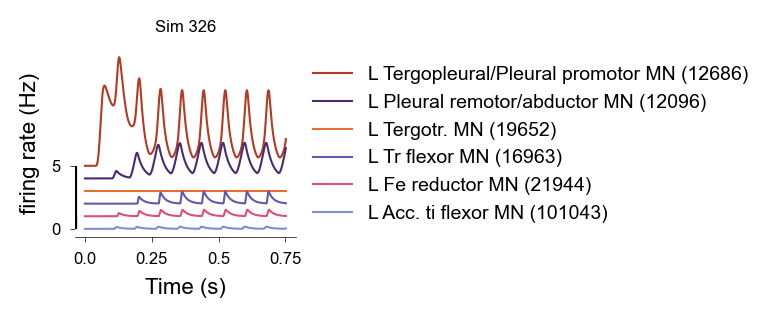

In [8]:
# simToPlot = np.random.choice(np.where(mnActive.loc[3051]>0)[0]) #np.random.randint(nSims)
simToPlot = 326
spacer = 1
scalebar = 5

# mnIdsToPlot = [19319, 12096, 16963, 21944, 101043, 19652] 
mnIdsToPlot = [12686, 12096, 16963, 21944, 101043, 19652] 
# ^ I picked a random Tergotrochanter MN bodyId because it doesn't matter because they're all silent.
# The principled thing would be to look at the one that matches whichever one's active in FANC

timeLimit = .75

###
R = Rs[simToPlot]

mnsToPlot = sort_motor_modules(wTable.loc[wTable["bodyId"].isin(mnIdsToPlot)])

plt.figure()
ax = plot_R_traces_stacked_by_module(R[:,:int(timeLimit/config.sim.dt)],mnsToPlot,activeOnly=False,space=spacer)
# ax = plot_R_traces_stacked_by_module(R[:,:int(timeLimit/config.sim.dt)],allMNs,activeOnly=True,space=spacer)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
fig.set_figheight(0.15*len(get_active_data(R[mnsToPlot.index],mnsToPlot)))
fig.set_figwidth(width)
plt.title(f"Sim {simToPlot}")

fig.set_figwidth(1.426)
fig.set_figheight(1.226)

plt.savefig(config.paths.fig_dir / f"{name}_representativeMnTraces_sim{simToPlot}.svg",transparent=True)

plt.show()

goodIdxs = 455, 331, 326* , 862, 990